##Загрузка и подготовка датасета

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
data = pd.read_csv('intern_task.csv')

In [21]:
data

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77591,0,10255,1.0,0.0,1.0,0.0,1.0,0.500000,0.0,0.500000,...,0.0,0.000000,0.000000,0.741386,8.263340,0.000000,0.010460,0.000083,4.0,2.000000
77592,0,10255,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
77593,0,10255,2.0,0.0,0.0,1.0,2.0,1.000000,0.0,0.000000,...,0.0,0.000000,0.111111,0.929144,0.000000,0.500000,0.015184,0.000031,13.0,6.500000
77594,0,10255,2.0,1.0,1.0,1.0,2.0,1.000000,0.5,0.500000,...,0.0,0.000000,0.166667,0.952131,8.263340,0.500000,0.012563,0.000012,12.0,6.000000


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77596 entries, 0 to 77595
Columns: 146 entries, rank to feature_143
dtypes: float64(140), int64(6)
memory usage: 86.4 MB


###Работа с пропусками и дубликатами

In [24]:
missing_values = data.isnull().sum()
print("Пропущенные значения в каждом столбце:\n", missing_values)
print("Всего пропусков:", missing_values.sum())

Пропущенные значения в каждом столбце:
 rank           0
query_id       0
feature_0      0
feature_1      0
feature_2      0
              ..
feature_139    1
feature_140    1
feature_141    1
feature_142    1
feature_143    1
Length: 146, dtype: int64
Всего пропусков: 16


In [25]:
data = data.dropna()

In [28]:
data.isnull().sum().sum()

0

In [26]:
duplicates = data.duplicated().sum()
print("Количество дубликатов в датасете:", duplicates)

Количество дубликатов в датасете: 0


##Обучение - LightGBM

Буду использовать LightGBM с функцией потерь "lambdarank", которая специально предназначена для задач ранжирования - так как мне он просто нравится и быстро работает




In [37]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import ndcg_score
from sklearn.metrics import average_precision_score, precision_score, recall_score

In [40]:
pip install --upgrade lightgbm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.6 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.1.0
    Uninstalling lightgbm-4.1.0:
      Successfully uninstalled lightgbm-4.1.0


In [34]:
features = [f for f in data.columns if f.startswith('feature')]
X = data[features]
y = data['rank']
query_id = data['query_id']

Добавим функцию, которая будет считать количество элементов в каждой группе (то есть для каждого уникального значения query_id). LightGBM требует указания размеров групп в датасете при обучении модели ранжирования, чтобы знать, какие строчки данных относятся к одной и той же поисковой сессии (query_id). Так, это позволяет корректно оптимизировать функцию потерь, учитывая структуру групп в данных

Грубо говоря, если у есть датасет, в котором одна и та же query_id повторяется несколько раз (например, для разных документов в рамках одного поискового запроса), то функция group_counts поможет сформировать массив, содержащий количество элементов в каждой из этих групп по query_id

In [36]:
def group_counts(query_ids):
    return query_ids.value_counts().sort_index().values

Модель буду обучать с помощью кросс-валидации, так как позволяет лучше оценить обобщающую способность модели, так как модель тестируется на разных подмножествах данных

In [42]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

ndcg_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    train_query_id, test_query_id = query_id.iloc[train_index], query_id.iloc[test_index]

    train_group = group_counts(train_query_id)
    valid_group = group_counts(test_query_id)

    train_data = lgb.Dataset(X_train, label=y_train, group=train_group)
    validation_data = lgb.Dataset(X_test, label=y_test, group=valid_group)

    params = {
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'ndcg_eval_at': [5],
        'boosting_type': 'gbdt',
        'learning_rate': 0.1,
        'num_leaves': 31,
        'min_data_in_leaf': 20,
        'num_iterations': 100,
        'verbose': -1
    }

    model = lgb.train(
        params,
        train_data,
        valid_sets=[validation_data]
    )

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    ndcg_score_val = ndcg_score([y_test], [y_pred], k=5)
    ndcg_scores.append(ndcg_score_val)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

In [43]:
mean_ndcg_score = np.mean(ndcg_scores)
print(f'Mean NDCG@5: {mean_ndcg_score}')

Mean NDCG@5: 0.8376226558652838


результат вполне неплохой, учитывая, что это среднее по всем фолдам кросс-валидации. Но посмотрим на каждый фолд по отдельности, чтобы убедиться в относительной стабильности

NDCG@5 for fold 1: 0.7648173586070209
NDCG@5 for fold 2: 0.9671987306219144
NDCG@5 for fold 3: 0.7997807481010406
NDCG@5 for fold 4: 0.7946030594984799
NDCG@5 for fold 5: 0.8617133824979639


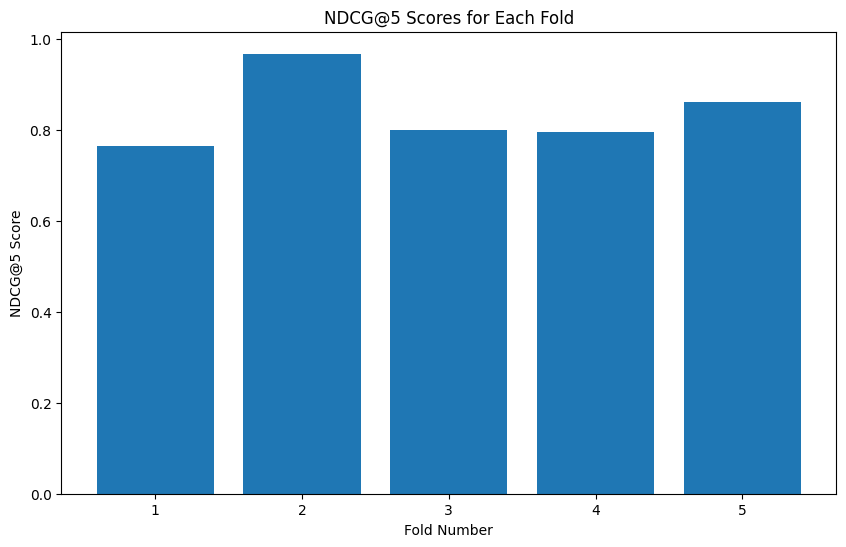

In [46]:
# NDCG@5 для каждого фолда
for i, score in enumerate(ndcg_scores):
    print(f'NDCG@5 for fold {i+1}: {score}')

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(ndcg_scores) + 1), ndcg_scores)
plt.xlabel('Fold Number')
plt.ylabel('NDCG@5 Score')
plt.title('NDCG@5 Scores for Each Fold')
plt.xticks(range(1, len(ndcg_scores) + 1))
plt.show()

Как видим, каких-то строгих отклонений нет - поэтому общий результат неплохой

##Обучение - XGBoosting

На LGB получилось неплохо, но на всякий случай посмотрим еще на XGB, которая также поддерживает оптимизацию для задач ранжирования с использованием функции потерь rank:pairwise или rank:ndcg

In [47]:
import xgboost as xgb

In [50]:
xgb_params = {
    'objective': 'rank:pairwise',  # можно попробовать также 'rank:ndcg'
    'eval_metric': 'ndcg',
    'learning_rate': 0.1,
    'max_depth': 6,
    'seed': 42
}

ndcg_scores_xgb = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)

    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

    model_xgb = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=100,
        evals=watchlist,
        early_stopping_rounds=10
    )


    y_pred_xgb = model_xgb.predict(dvalid, iteration_range=(0, model_xgb.best_iteration + 1))

    ndcg_score_val_xgb = ndcg_score([y_test], [y_pred_xgb], k=5)
    ndcg_scores_xgb.append(ndcg_score_val_xgb)

[0]	train-ndcg:0.15170	valid-ndcg:0.05857
[1]	train-ndcg:0.20605	valid-ndcg:0.07012
[2]	train-ndcg:0.22281	valid-ndcg:0.04562
[3]	train-ndcg:0.20125	valid-ndcg:0.03862
[4]	train-ndcg:0.20445	valid-ndcg:0.04147
[5]	train-ndcg:0.20273	valid-ndcg:0.04074
[6]	train-ndcg:0.20837	valid-ndcg:0.04301
[7]	train-ndcg:0.21010	valid-ndcg:0.05035
[8]	train-ndcg:0.20921	valid-ndcg:0.04894
[9]	train-ndcg:0.20432	valid-ndcg:0.05723
[10]	train-ndcg:0.20462	valid-ndcg:0.03991
[11]	train-ndcg:0.20372	valid-ndcg:0.04474
[0]	train-ndcg:0.12879	valid-ndcg:0.06938
[1]	train-ndcg:0.18048	valid-ndcg:0.13769
[2]	train-ndcg:0.20299	valid-ndcg:0.12167
[3]	train-ndcg:0.21418	valid-ndcg:0.11652
[4]	train-ndcg:0.25181	valid-ndcg:0.09282
[5]	train-ndcg:0.25262	valid-ndcg:0.10075
[6]	train-ndcg:0.28594	valid-ndcg:0.09703
[7]	train-ndcg:0.30384	valid-ndcg:0.09615
[8]	train-ndcg:0.35147	valid-ndcg:0.11002
[9]	train-ndcg:0.34322	valid-ndcg:0.09658
[10]	train-ndcg:0.34108	valid-ndcg:0.09323
[0]	train-ndcg:0.21182	valid-nd

In [51]:
mean_ndcg_score_xgb = np.mean(ndcg_scores_xgb)
print(f'Mean NDCG@5 for XGBoost: {mean_ndcg_score_xgb}')

Mean NDCG@5 for XGBoost: 0.2831334431709835


Как мы видим для XGB значение получилось значительно хуже, чем для LGB. Возможно недостаточно хорошо подобраны гиперпараметры, недостаточно иттераций или модель в целом не подходит и хуже справляется

В целом, результаты LightGBM говорят о том, что эта модель лучше подходит для этой задачи ранжирования с учетом текущих данных и настроек